Set parameter Username
Academic license - for non-commercial use only - expires 2023-11-15
Set parameter NonConvex to value 2
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: 12th Gen Intel(R) Core(TM) i7-12700, instruction set [SSE2|AVX|AVX2]
Thread count: 20 physical cores, 20 logical processors, using up to 20 threads

Optimize a model with 4637 rows, 4632 columns and 13095 nonzeros
Model fingerprint: 0x4f437117
Model has 666 quadratic constraints
Model has 12 general constraints
Variable types: 4602 continuous, 30 integer (30 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+13]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [3e-01, 1e+00]
  Objective range  [2e-03, 2e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+02]
  QRHS range       [7e+00, 2e+03]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.

---------------------------------------------------------------

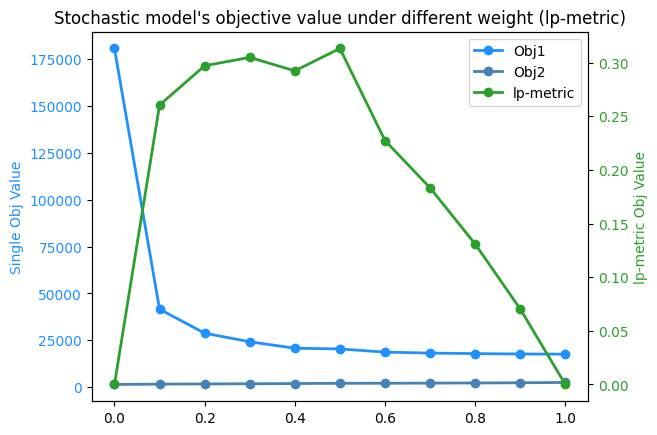

          w         Obj1       Obj2 lp-metric
*   17549.9    1363.9200                     
0       0.0  180700.9436    1363.92       0.0
1       0.1   41532.8434    1551.54    0.2605
2       0.2   28737.8227  1653.1819    0.2972
3       0.3   24167.7728  1737.6311    0.3049
4       0.4   20719.8217  1864.3808    0.2924
5       0.5   20327.0690    2002.62    0.3133
6       0.6   18643.5926  2011.9806    0.2274
7       0.7   18111.5798  2095.4404    0.1833
8       0.8   17844.7266  2165.2516    0.1309
9       0.9   17632.1978  2265.6105    0.0703
10      1.0   17549.9000    2455.15       0.0
Set parameter NonConvex to value 2
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: 12th Gen Intel(R) Core(TM) i7-12700, instruction set [SSE2|AVX|AVX2]
Thread count: 20 physical cores, 20 logical processors, using up to 20 threads

Optimize a model with 4637 rows, 4632 columns and 13095 nonzeros
Model fingerprint: 0x67453342
Model has 666 quadratic constraints
Model has 12 gen

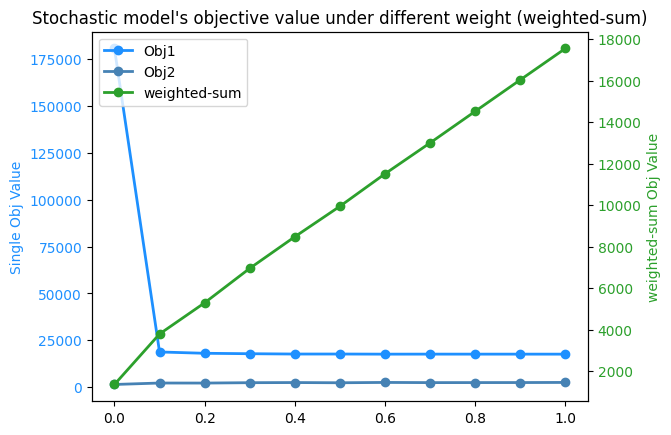

      w         Obj1     Obj2  weighted-sum
0   0.0  180700.9436  1363.92     1363.9200
1   0.1   18718.5022  2138.47     3796.4732
2   0.2   18013.5829  2118.84     5297.7886
3   0.3   17782.6741  2317.87     6957.3112
4   0.4   17611.6564  2392.75     8480.3126
5   0.5   17616.1931  2278.87     9947.5315
6   0.6   17549.9000  2455.15    11512.0000
7   0.7   17562.9897  2357.65    13001.3878
8   0.8   17557.3509  2377.54    14521.3887
9   0.9   17554.8447  2390.80    16038.4402
10  1.0   17549.9000  2455.15    17549.9000
Set parameter NonConvex to value 2
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: 12th Gen Intel(R) Core(TM) i7-12700, instruction set [SSE2|AVX|AVX2]
Thread count: 20 physical cores, 20 logical processors, using up to 20 threads

Optimize a model with 4636 rows, 4632 columns and 13080 nonzeros
Model fingerprint: 0x1f32a502
Model has 666 quadratic constraints
Model has 12 general constraints
Variable types: 4602 continuous, 30 integer (30 binar

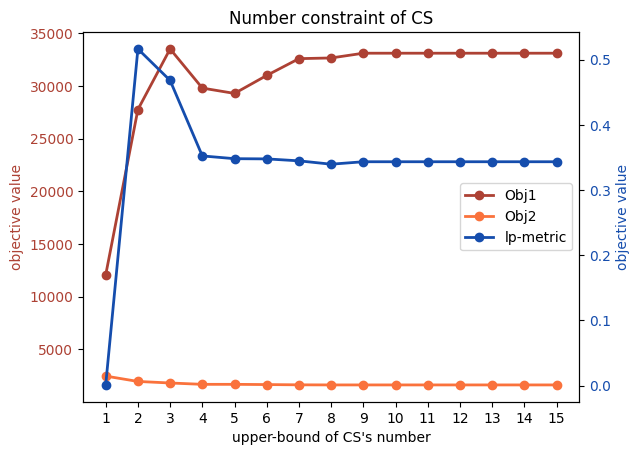

Set parameter NonConvex to value 2
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: 12th Gen Intel(R) Core(TM) i7-12700, instruction set [SSE2|AVX|AVX2]
Thread count: 20 physical cores, 20 logical processors, using up to 20 threads

Optimize a model with 4637 rows, 4632 columns and 13095 nonzeros
Model fingerprint: 0x4f437117
Model has 666 quadratic constraints
Model has 12 general constraints
Variable types: 4602 continuous, 30 integer (30 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+13]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [3e-01, 1e+00]
  Objective range  [2e-03, 2e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+02]
  QRHS range       [7e+00, 2e+03]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.

---------------------------------------------------------------------------
Multi-objectives: starting optimization with 2 objectives (1 combined) ...
---

In [1]:
import numpy as np

import sp_model 
from util import to_range, DATA_PATH, FIG_PATH, OptimizationMethod
from sp_model import SET, PARAMETER

# import gurobipy as gp
# with gp.Env(empty=True) as env:
#     env.setParam('OutputFlag', 0)
#     env.start()
#     with gp.Model(env=env) as m:
# %%
d = dict()
w = 0.1
eps = [7,8]
# 有一個趨勢是幾乎每個點都會開立一個rdc, cs，很像沒有不開的。
m, obj1, obj2 = sp_model.solve(1, OptimizationMethod.WEIGHTED_SUM)
obj1_star = obj1.getValue() 
m, obj1, obj2 = sp_model.solve(0, OptimizationMethod.WEIGHTED_SUM)
obj2_star = obj2.getValue()
objstars = [obj1_star, obj2_star]



# for w in np.arange(0.01, 0.2, 0.01):
spm, o1, o2 = sp_model.solve(w,
            OptimizationMethod.LP_METRIC,
            single_objval = objstars, eps = eps)
alpha, beta = [], [] 
for j in to_range(SET['J']):
    alpha_j = spm.getVarByName(f'alpha[{j}]').x
    beta_j = spm.getVarByName(f'beta[{j}]').x
    alpha.append(alpha_j)
    beta.append(beta_j)
    d[str(w)] = {'#RDC': sum(alpha), '#CS': sum(beta)}
# ============================ 
# soldict = {} 
# for rdc_num in to_range(SET['J']):
#     eps = [rdc_num, 15 - rdc_num - 1] 
#     model = sp_model.solve(w,  
#         OptimizationMethod.WEIGHTED_SUM, 
#         eps = eps)
#     try: 
#         print(model.objVal) 
#         soldict[rdc_num]
#     except: 
#         print('infeasible')
#         pass 
    

In [2]:
for j in to_range(SET['J']):
   for c in to_range(SET['C']):
    for s in to_range(SET['S']): 
        delta = spm.getVarByName('delta[0,0,0]').x
        if delta != 0 :
            print(f'j={j}, c={c}, s={s}, delta={delta}')

In [3]:
# get supplier names 
import pandas as pd 
PATH_PREFIX = 'MoDRL_'
df_supplier = pd.read_csv(DATA_PATH 
+ f'/{PATH_PREFIX}supplier.csv')
suppliers = df_supplier['Suppliers'].values 

df_distance = pd.read_csv(DATA_PATH + f'/{PATH_PREFIX}distance.csv')
AA = df_distance.columns.values
J = AA
print(suppliers)
print(AA)
Commodities = ['Water', 'Food', 'Shelter']

['Sari' 'Qazvin' 'Tehran' 'Arak' 'Isfahan']
['Gorgan' 'Semnan' 'Sari' 'Rasht' 'Qazvin' 'Karaj' 'Tehran' 'Varamin'
 'Robatkarim' 'Islamshahr' 'Shahriar' 'Gom' 'Arak' 'Isfahan' 'Kashan']


### $\alpha_j, \beta_j$ Build RDC/CS or not 

In [5]:
from sp_model import SET, PARAMETER
alpha, beta = [], [] 
for j in to_range(SET['J']):
    alpha_j = spm.getVarByName(f'alpha[{j}]').x
    beta_j = spm.getVarByName(f'beta[{j}]').x
    # alpha_i: build RDC or not 
    # beta_i: build CS or not
    alpha.append(alpha_j)
    beta.append(beta_j)
    # print(AA[i], alpha_i, beta_i)
build_df = pd.DataFrame({'RDC': alpha, 'CS': beta}, index=AA)
build_df = build_df.transpose() 
build_df

,Gorgan,Semnan,Sari,Rasht,Qazvin,Karaj,Tehran,Varamin,Robatkarim,Islamshahr,Shahriar,Gom,Arak,Isfahan,Kashan
RDC,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
CS,-0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0


In [6]:
print(f'RDC #: {sum(alpha)}')
print(f'CS #: {sum(beta)}')

RDC #: 7.0
CS #: 8.0


In [7]:
i, j, k, k_prime, s, c = [len(idx) for idx in SET.values()]
import numpy as np 
Q = np.zeros((i, j, c))
X = np.zeros((i, j, c, s))
Y = np.zeros((j, k, c, s))

### $Q_{ijc}, X_{ijcs}$ transported commodities to RDC/CS

In [8]:
## in preparedness phase 
## get Q_ijc: Sup to RDC/CS
for i in to_range(SET['I']):
    for j in to_range(SET['J']):
        for c in to_range(SET['C']):
            Q[i, j, c] = spm.getVarByName(f'Q[{i},{j},{c}]').x
            if Q[i, j, c] > 0: 
                print(f'Supplier {suppliers[i]} => {J[j]} {Commodities[c]} : {Q[i, j, c]}') 

In [ ]:
## response phase 
#  get X_ijcs: Sup to RDC/CS in response phase 
print('======= RDC =======')
for i in to_range(SET['I']):
    for j in to_range(SET['J']):
        for c in to_range(SET['C']):
            s_vec = np.zeros(len(SET['S']))
            for s in to_range(SET['S']):
                X[i, j, c, s] = spm.getVarByName(f'X[{i},{j},{c},{s}]').x
                s_vec[s] = X[i, j, c, s] 
            if np.sum(s_vec) != 0 and alpha[j]: 
                print(f'{suppliers[i]} => {AA[j]}', Commodities[c], s_vec)

: 

In [9]:
import os 
from copy import deepcopy
from util import RESULT_PATH

def PrecisionTuple(x):
    return '(' + ', '.join(('%.1f' % f) for f in x) + ')'


Xfilename = os.path.join(RESULT_PATH, 'X_ijcs.csv')

print(f'======= CS =======')
rowdict = {} 
for i in to_range(SET['I']):
    for c in to_range(SET['C']):
        row = np.zeros((len(SET['J']))).tolist()
        for j in to_range(SET['J']):
            s_vec = np.zeros(len(SET['S']))
            for s in to_range(SET['S']):
                X[i, j, c, s] = spm.getVarByName(f'X[{i},{j},{c},{s}]').x
                s_vec[s] = X[i, j, c, s] 
            # if np.sum(s_vec) != 0 and beta[j]:
            #     print(f'{suppliers[i]} => {AA[j]}', Commodities[c], s_vec)
            if np.sum(s_vec) != 0:
                row[j] = PrecisionTuple(s_vec) 
            else: row[j] = '-'
        rowname = f'{suppliers[i]}_{Commodities[c]}'
        rowdict[rowname] = deepcopy(row)

rowdict = {k: v for k, v in sorted(rowdict.items(), key=lambda item: item[0])}
Xijcs = pd.DataFrame.from_dict(rowdict, orient = 'index', columns=AA)
Xijcs = Xijcs.round(2)
Xijcs 
Xijcs.to_csv(Xfilename)

======= CS =======


### $Y_{jkcs}$ transported commodities to AA

In [10]:
    
def isNotZero(x):
    return abs(x) > 1e-6

import os 
from copy import deepcopy
from util import RESULT_PATH

Yfilename = os.path.join(RESULT_PATH, 'Y_jkcs.csv')
rowdict = {} 
for j in to_range(SET['J']):
    if not (alpha[j] or beta[j]):
        continue 
 
    for c in to_range(SET['C']):
        
        row = np.zeros((len(SET['K']))).tolist()
        for k in to_range(SET['K']):
            
            s_vec = np.zeros(len(SET['S']))
            for s in to_range(SET['S']):
                Y[j, k, c, s] = spm.getVarByName(f'Y[{j},{k},{c},{s}]').x
                s_vec[s] = Y[j, k, c, s] 
            # if np.sum(s_vec) != 0: 
                # print(f'{suppliers[i]} => {AA[j]}', Commodities[c], s_vec)
            if np.sum(s_vec) != 0: 
                print(f'{suppliers[i]} => {AA[j]}', Commodities[c], s_vec)
                row[k] = PrecisionTuple(s_vec) 
            else: 
                row[k] = '-'
        rowname = f'{J[j]}_{Commodities[c]}'
        rowdict[rowname] = deepcopy(row)

rowdict = {k: v for k, v in sorted(rowdict.items(), key=lambda item: item[0])}
Yjkcs = pd.DataFrame.from_dict(rowdict, orient = 'index', columns=AA)
Yjkcs.to_csv(Yfilename)

Isfahan => Sari Water [  0. 117. 117. 117.]
Isfahan => Sari Food [45.2  0.   0.   0. ]
Isfahan => Sari Food [71.8  0.   0.   0. ]
Isfahan => Sari Food [  0. 117. 117. 117.]
Isfahan => Sari Shelter [ 0.  0. 39. 39.]
Isfahan => Karaj Food [ 0.  0. 75.  0.]
Isfahan => Tehran Water [55.  0.  0.  0.]
Isfahan => Tehran Food [305.2   0.    0.    0. ]
Isfahan => Islamshahr Water [  0.  249.6 249.6 249.6]
Isfahan => Islamshahr Food [  0.  249.6 249.6 249.6]
Isfahan => Islamshahr Shelter [ 0.  83.2 83.2 83.2]
Isfahan => Shahriar Water [  0. 117. 117. 117.]
Isfahan => Shahriar Food [61.4  0.   0.   0. ]
Isfahan => Shahriar Food [  0. 117. 117. 117.]
Isfahan => Shahriar Shelter [ 0. 39. 39. 39.]
Isfahan => Arak Food [  0.   0. 100.   0.]
Isfahan => Isfahan Water [  0. 117. 117. 117.]
Isfahan => Isfahan Food [117.   0.   0.   0.]
Isfahan => Isfahan Food [  0. 117. 117. 117.]
Isfahan => Isfahan Shelter [ 0.  0. 39.  0.]


### $I_{kcs}$: the inventory held at AA k for commod c under s 
### $b_{kcs}$: the shortage held at AA k for commod c under s  

In [11]:
k, c, s = len(SET['K']), len(SET['C']), len(SET['S'])
I = np.zeros((k, c, s))
b = np.zeros((k, c, s))


rows_i = {} 
rows_b = {}
for c in to_range(SET['C']): 
    row_i = []
    row_b = []

    for k in to_range(SET['K']):
        s_vec_i = np.zeros(len(SET['S'])) 
        s_vec_b = np.zeros(len(SET['S'])) 
        for s in to_range(SET['S']):
            I[k, c, s] = spm.getVarByName(f'I[{k},{c},{s}]').x
            b[k, c, s] = spm.getVarByName(f'b[{k},{c},{s}]').x

            s_vec_i[s] = I[k, c, s] 
            s_vec_b[s] = b[k, c, s]
        if np.sum(s_vec_i) == 0: 
            row_i.append('-')
        else:  
            row_i.append(PrecisionTuple(s_vec_i))
        if np.sum(s_vec_b) == 0:
            row_b.append('-')
        else:
            row_b.append(PrecisionTuple(s_vec_b))

    rowname = f'{Commodities[c]}'
    rows_i[rowname] = deepcopy(row_i) 
    rows_b[rowname] = deepcopy(row_b)

b_kcs = pd.DataFrame.from_dict(rows_b, orient = 'index', columns=AA)
Bfilename = os.path.join(RESULT_PATH, 'b_kcs.csv')
b_kcs.to_csv(Bfilename)
i_kcs = pd.DataFrame.from_dict(rows_i, orient = 'index', columns=AA)
Ifilename = os.path.join(RESULT_PATH, 'I_kcs.csv')
i_kcs.to_csv(Ifilename)